## MBA em Ciência de Dados
# Redes Neurais e Arquiteturas Profundas

### <span style="color:darkred">Módulo IV - Estratégias de Treinamento e Transferência de Aprendizado</span>


### <span style="color:darkred">Monitoria 27/10</span>

Moacir Antonelli Ponti

CeMEAI - ICMC/USP São Carlos

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from numpy.random import seed
from tensorflow.random import set_seed

fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images = train_images / 255.0
test_images = test_images / 255.0

train_labels = keras.utils.to_categorical(train_labels, 10)
test_labels = keras.utils.to_categorical(test_labels, 10)

4431872/4422102 [==============================] - 0s 0us/step


In [10]:
# comando para verificar se há GPU disponivel
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU'))) 

Num GPUs Available:  1


In [2]:
# pegando tamanho da entrada
input_shape = train_images[0].shape
print(input_shape)
print(len(input_shape))

(28, 28)
2


In [3]:
# verifica se a imagem tem só 2 dimensoes, se tiver entao inclui uma vazia
if len(input_shape) == 2:
    # expande a dimensao da entrada 
    input_shape = train_images[0].shape + (1,)
    print(input_shape)

(28, 28, 1)


In [4]:
no_imagens = 6000

train_sub = train_images[:no_imagens]
train_lab_sub = train_labels[:no_imagens]

val_sub = train_images[no_imagens:no_imagens+1000]
val_lab_sub = train_labels[no_imagens:no_imagens+1000]

Exemplo de uma sequencia de camadas a ser inserida em um modelo

In [13]:
# modelo sequencial
camada_aumento = keras.Sequential(
    [
        layers.BatchNormalization(),
        # procurar na documentacao do tensorflow/Keras por preprocessing
        layers.experimental.preprocessing.RandomFlip("horizontal"),        
    ]
)

In [19]:
def cnn_model(input_shape, n_classes):
    inp = layers.Input(shape=input_shape)
    # inserimos a sequencia aqui, que pode conter qualquer camada e fica "encapsulada"
    aum = camada_aumento(inp)
    conv1 = layers.Conv2D(10, 3, activation="relu", padding="same", name="conv_1")(aum)
    maxp1 = layers.MaxPooling2D(2, strides=(2,2), padding="same")(conv1)
    # poderíamos usar também Layer Normalization ou Instance Normalization
    bn = layers.BatchNormalization()(maxp1)
    conv2 = layers.SeparableConv2D(50, 3, activation="relu", padding="same", name="conv_2")(bn)
    maxp2 = layers.MaxPooling2D((3,3), strides=2, padding="same")(conv2)
    #flat = layers.Flatten()(maxp2)
    gpol = layers.GlobalAveragePooling2D(name="avg_pool")(maxp2)
    out = layers.Dense(n_classes, activation="sigmoid")(gpol)
    cnn = keras.Model(inp, out)
    return cnn


In [15]:
model = cnn_model(input_shape, 10)
model.summary()   

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 28, 28, 1)         4         
_________________________________________________________________
conv_1 (Conv2D)              (None, 28, 28, 10)        100       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 10)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 14, 14, 10)        40        
_________________________________________________________________
conv_2 (SeparableConv2D)     (None, 14, 14, 50)        640       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 7, 7, 50)          0   

In [16]:
seeds = [10, 15, 203, 13, 44]

for s in seeds:
    print('Semente', s)
    seed(s)
    set_seed(s)

    # instancia e inicializa o modelo aleatoriamente
    model = cnn_model(input_shape, 10)
    
    model.compile(loss="categorical_crossentropy", 
                  optimizer=keras.optimizers.Adam(learning_rate=0.001), 
                  metrics=['accuracy'])
    
    model.fit(train_sub, train_lab_sub, epochs=5,
              batch_size=10, validation_data=(val_sub, val_lab_sub),
              verbose=0)
    
    scores = model.evaluate(val_sub,val_lab_sub, verbose=0)
    print('\t Loss %.4f, Acc %.4f ' % (scores[0], scores[1]))
    

Semente 10
	 Loss 0.8598, Acc 0.6860 
Semente 15
	 Loss 0.8624, Acc 0.7050 
Semente 203
	 Loss 0.9058, Acc 0.7060 
Semente 13
	 Loss 0.9038, Acc 0.6890 
Semente 44
	 Loss 0.8454, Acc 0.7200 


Exemplo de "remontagem" do modelo usando camadas anteriores à de saída original

In [24]:
model = cnn_model(input_shape, 10)

# pegar saida de uma camada existente
# opcao 1 : por índice
layer_output = model.layers[-4].output
# opcao 2 : por nome
layer_output = model.get_layer('conv_2').output

modelo_extrator = keras.models.Model(model.inputs, layer_output)
modelo_extrator.summary()

Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 28, 28, 1)         4         
_________________________________________________________________
conv_1 (Conv2D)              (None, 28, 28, 10)        100       
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 14, 14, 10)        0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 14, 14, 10)        40        
_________________________________________________________________
conv_2 (SeparableConv2D)     (None, 14, 14, 50)        640       
Total params: 784
Trainable params: 762
Non-trainable params: 22
___________________________________________________________

In [25]:
# usando o modelo novo para obter predicoes
feats_val = modelo_extrator.predict(val_sub)
print(feats_val.shape)

(1000, 14, 14, 50)


In [26]:
# como as dimensoes da saída não são como desejamos
# podemos criar uma "nova" camada e remontar o modelo

# pegar saida de uma camada
# opcao 1 : por índice
# layer_output = model.layers[-4].output
# opcao 1 : por nome
layer_output = model.get_layer('conv_2').output

# cria uma camada nova que processa a saída da camada conv_2
camada_nova = layers.Flatten()(layer_output)

# gera modelo
modelo_extrator = keras.models.Model(model.inputs, camada_nova)
modelo_extrator.summary()

Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 28, 28, 1)         4         
_________________________________________________________________
conv_1 (Conv2D)              (None, 28, 28, 10)        100       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 14, 14, 10)        0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 14, 14, 10)        40        
_________________________________________________________________
conv_2 (SeparableConv2D)     (None, 14, 14, 50)        640       
_________________________________________________________________
flatten (Flatten)            (None, 9800)              0  

In [34]:
# extrai features
feats_val = modelo_extrator.predict(val_sub)
print(feats_val.shape)

# usa com outros métodos
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=2)
pca.fit(feats_val)

tsne = TSNE(n_components=2)
dados_tsne = tsne.fit_transform(feats_val)
print(dados_tsne.shape)

(1000, 9800)
(1000, 2)


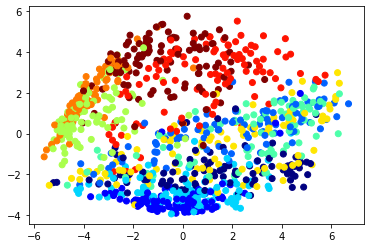

In [42]:
plt.scatter(dados_pca[:,0], dados_pca[:,1], c=np.argmax(val_lab_sub,axis=1), cmap="jet")

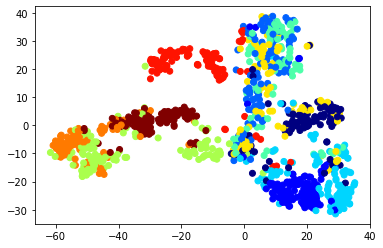

In [43]:
plt.scatter(dados_tsne[:,0],dados_tsne[:,1], c=np.argmax(val_lab_sub,axis=1), cmap="jet")

Sobre Normalização

Considere:
- Base de dados treinamento X
- Base de dados de teste T

Se fizer normalização Min-max antes:
- *Todas* as instancias de X são normalizadas considerando o min e max de X
- Cada instancias de T será normalizada (em tempo de inferencia) considerando o min e max de X


Na normalizacao usando camadas:
- Se usar Batch-size = b
- Para cada 'b' instancias essas instancias são normalizadas considerando os valores min max dentro do batch.

BatchNormalization em treinamento
- cada batch atualiza a média e a variância do "Standard Scaler", que se acumula

BatchNormalization em inferência (após treinamento)
- a última média e variância computadas no treinamento são usadas para todos os elementos durante inferência (teste)